In [1]:
import torch; torch.manual_seed(0)
import torch.distributions
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import pandas as pd
import ipdb
import os, sys, glob
from sklearn.model_selection import train_test_split
import seaborn as sns
import json
from sklearn.manifold import TSNE
import pathlib
from collections import Counter
from os.path import dirname, join, abspath
sys.path.insert(0, abspath(join(dirname("__file__"), '..')))
from models.vanilla_vae import VanillaVAE
from utils import ProgressMeter, AverageMeter, save_checkpoint, TiffDataset

/home/kangzigi/miniconda3/envs/pixel-ai/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load best Model

In [2]:
# declaring the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 250
batch_size = 256
lr = 0.001
latent_dims = 8
channels = [0, 1, 2]
in_channels = len(channels)
hidden_dims = [ 16, 32, 64, 128, 256]
best_loss_val = 99999999
kld_weight = 0.000025
input_dimensions = (128, 128)

transform_to_image = T.ToPILImage()
cores_folder = 'TMA_18_810/'
files_path='/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/randomly_generated/{0}'.format(cores_folder)
model_path='/data/projects/pixel_project/saved_models'
model_name = "model_best_allcores_randompatches_[0, 1, 2]"

model = VanillaVAE(in_channels=in_channels, latent_dim=latent_dims, input_dimensions=input_dimensions, hidden_dims=hidden_dims).to(device) # GPU
checkpoint = torch.load('{}/{}_vae.pth.tar'.format(model_path, model_name))

for key in list(checkpoint['state_dict'].keys()):
    if 'module.' in key:
        checkpoint['state_dict'][key.replace('module.', '')] = checkpoint['state_dict'][key]
        del checkpoint['state_dict'][key]

model.load_state_dict(checkpoint['state_dict'])
model.eval()

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Seque

## Apply model on dataset and extract Latent space

In [52]:
import random

patches_files = [os.path.join(r, fn)
        for r, ds, fs in os.walk(files_path)
        for fn in fs if fn.endswith('.tiff')]
tiff_dataset = TiffDataset(files=patches_files, 
transform=T.Resize(input_dimensions), 
channels=channels) # random.choices(patches_files, k=4000)

data_loader = torch.utils.data.DataLoader(
    tiff_dataset, batch_size=batch_size, 
    shuffle=None, pin_memory=True, 
    sampler=None
    )

In [53]:
latent_list = []

for i, images in enumerate(data_loader):
    images = images.cuda()
    x_hat = model(images)
    loss = model.loss_function(*x_hat, M_N=kld_weight)
    z = x_hat[4]
    value = z.cpu().detach().numpy()
    latent_list.append(value)

all_value = np.vstack(latent_list)

In [57]:
np.save('../data/{}_latent_space.npy'.format(model_name), all_value)

## Visualize Latent Space

### UMAP

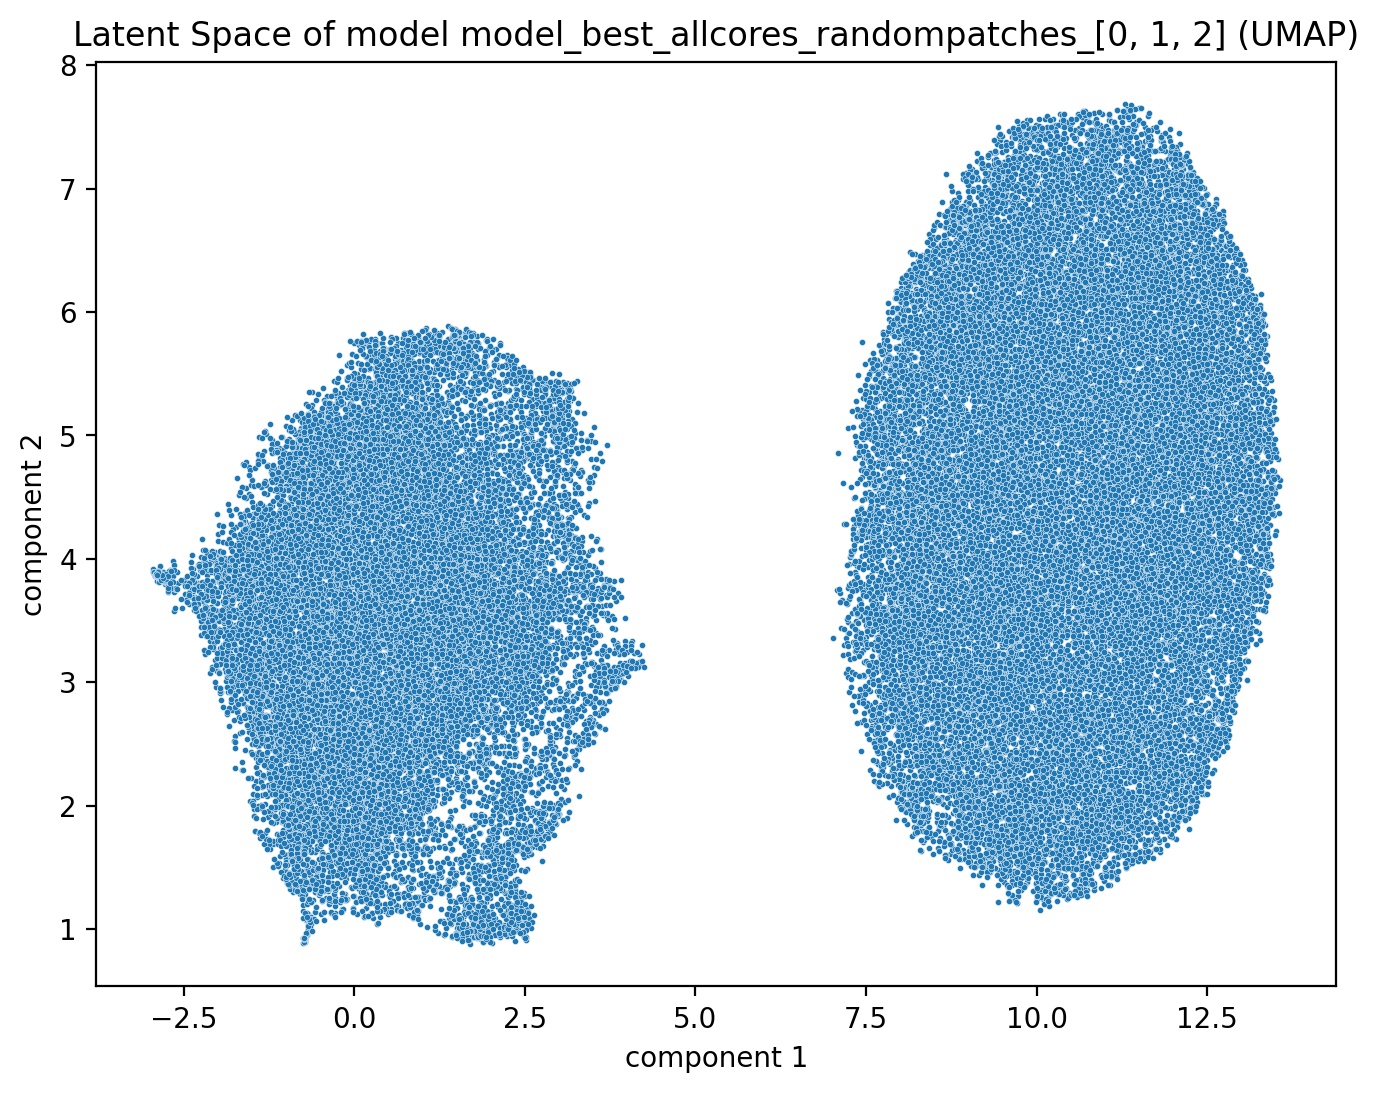

In [55]:
import umap.umap_ as umap

proj_2d = pd.DataFrame(
        data=umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, metric='euclidean').fit_transform(all_value),
        columns=["component 1", "component 2"]
        )

plt.figure(figsize=(8, 6))
sns.scatterplot(data=proj_2d, x="component 1", y="component 2", alpha=1, s=5)
plt.title("Latent Space of model {} (UMAP)".format(model_name))
plt.show()

In [73]:
proj_2d_cluster1 = proj_2d.query('(`component 1` >= 5)').sample(n=10) # random select samples in each clusters
proj_2d_cluster2 = proj_2d.query('(`component 1` <= 5)').sample(n=10)

In [79]:
patch_1 = []
for i in proj_2d_cluster1.index:
    patch_1.append(patches_files[i])

patch_2 = []
for i in proj_2d_cluster2.index:
    patch_2.append(patches_files[i])

#### Plot origin patches in each clusters

Channel DAPI(0) median = 108.0, mean = 108.7442626953125, std = 22.516433425661383


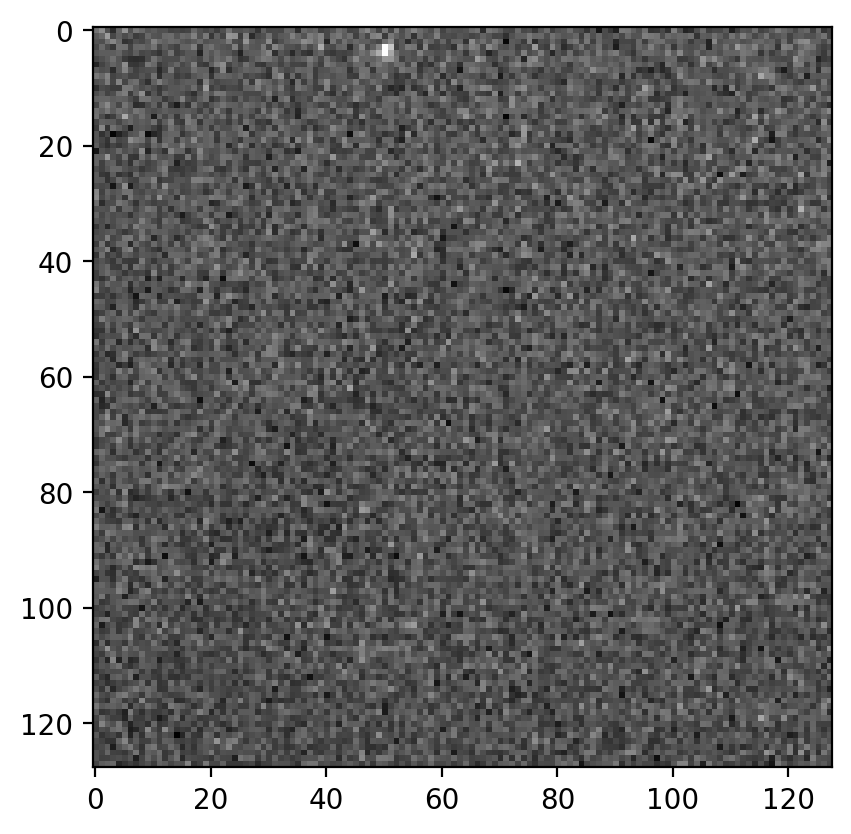

Channel DAPI(0) median = 104.0, mean = 105.10491943359375, std = 30.247760929180536


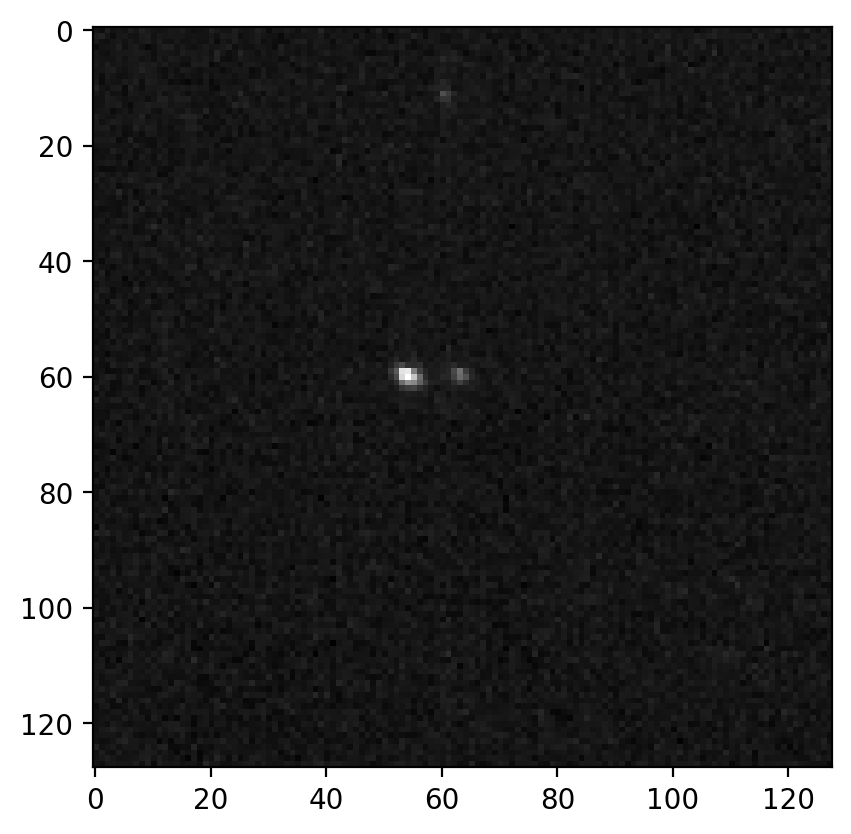

Channel DAPI(0) median = 149.0, mean = 149.59515380859375, std = 28.233615849139348


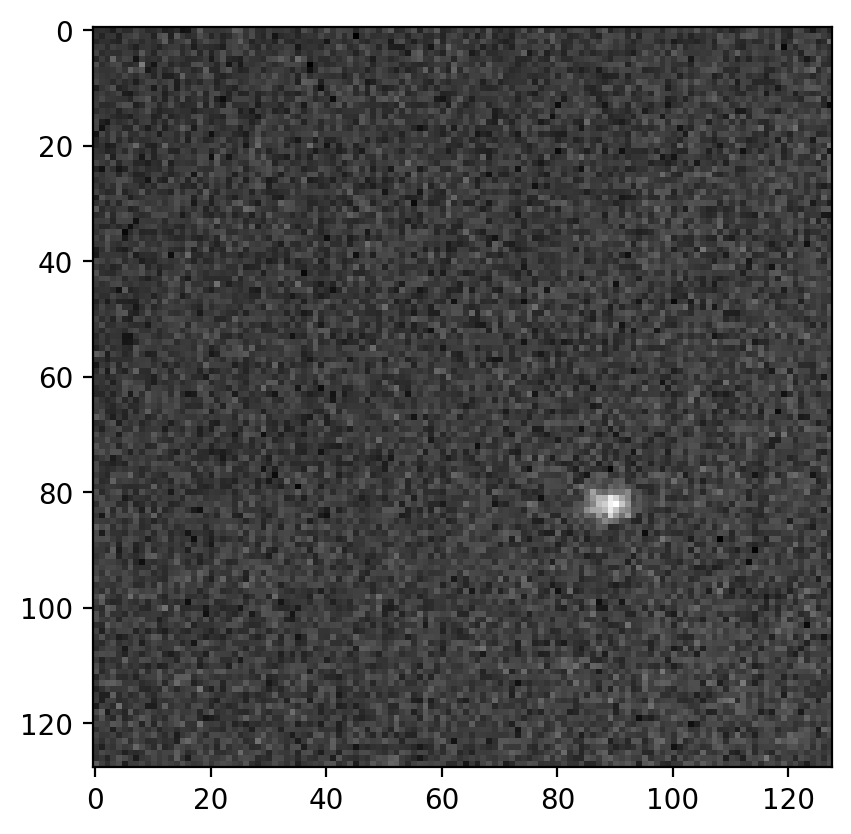

Channel DAPI(0) median = 225.0, mean = 225.63311767578125, std = 30.369708489659473


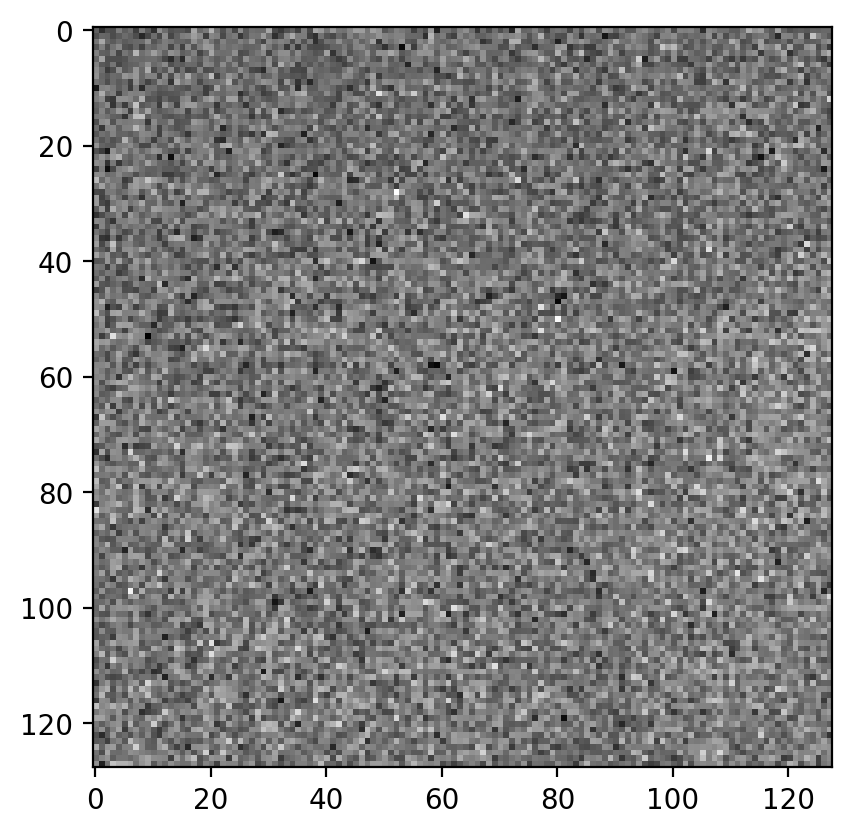

Channel DAPI(0) median = 281.0, mean = 281.69012451171875, std = 29.61554371978474


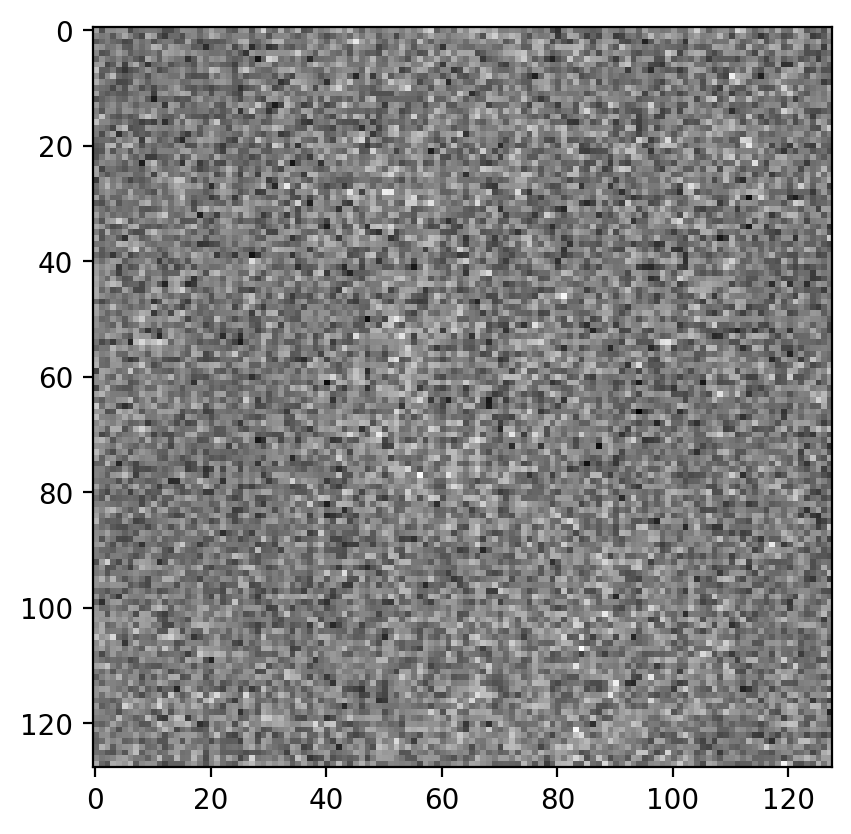

Channel DAPI(0) median = 186.0, mean = 186.66815185546875, std = 25.291972701958766


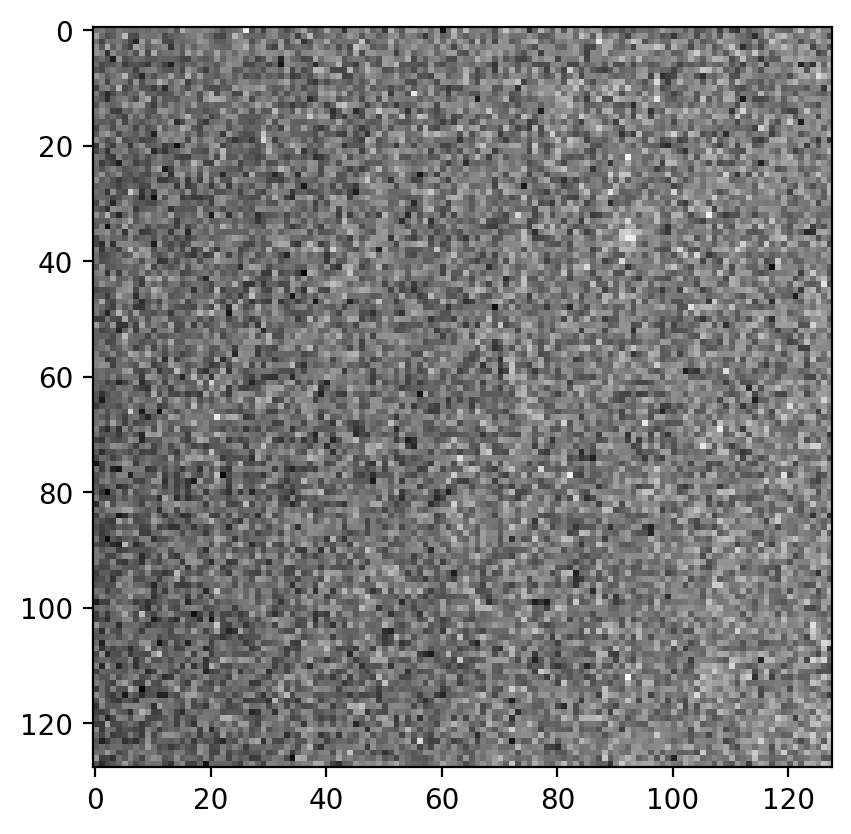

Channel DAPI(0) median = 179.0, mean = 180.3900146484375, std = 32.76848965034289


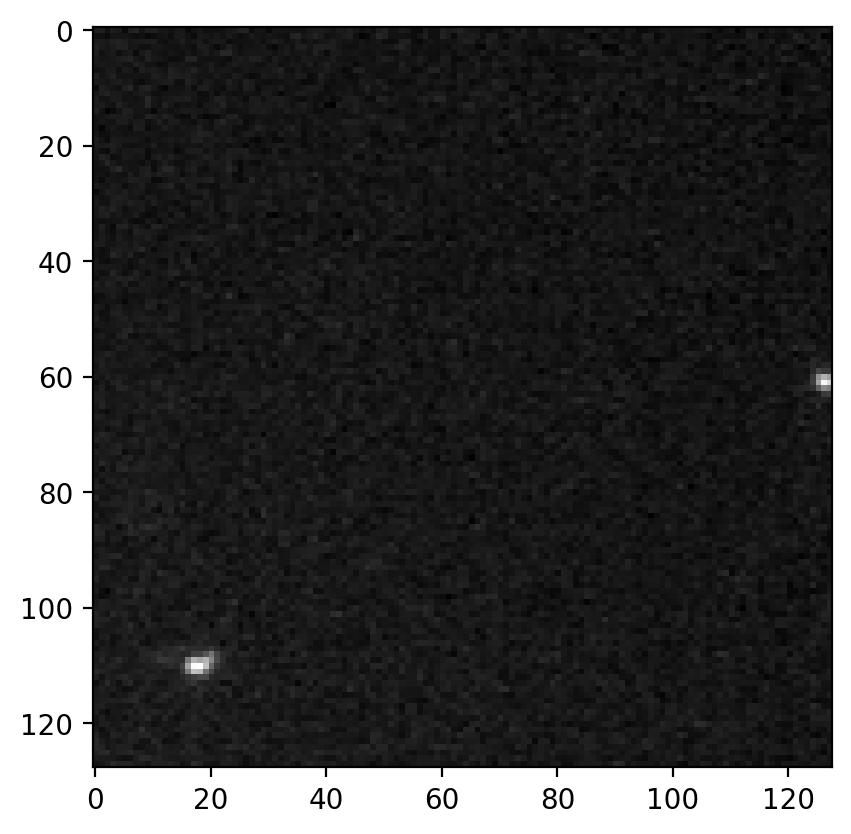

Channel DAPI(0) median = 218.0, mean = 1017.3519287109375, std = 2724.696367549169


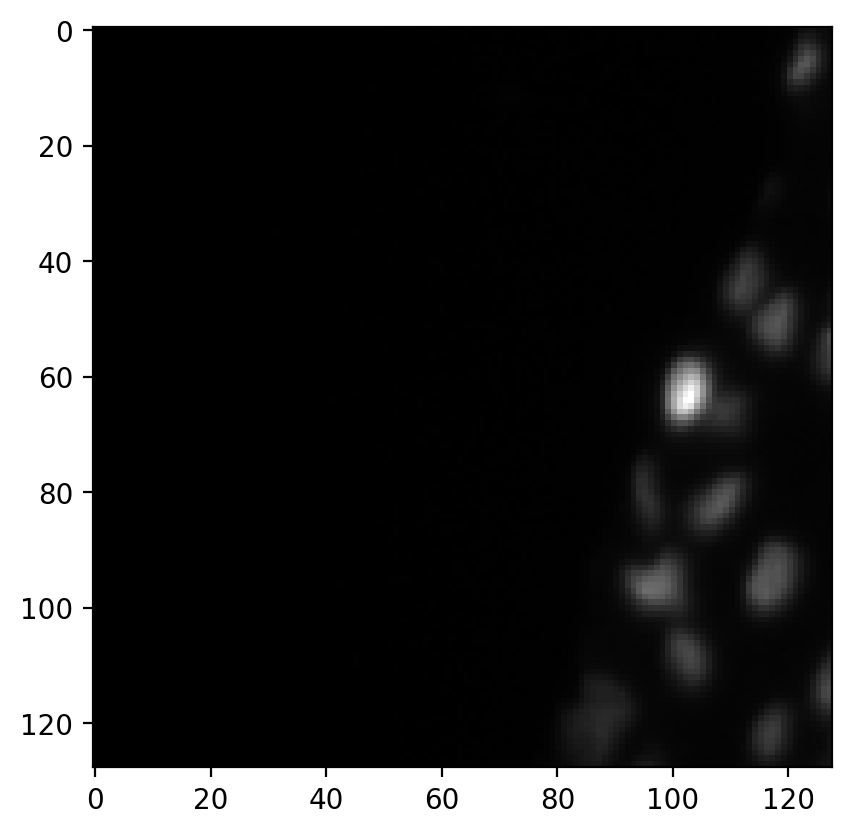

Channel DAPI(0) median = 247.0, mean = 286.38421630859375, std = 373.91673407443875


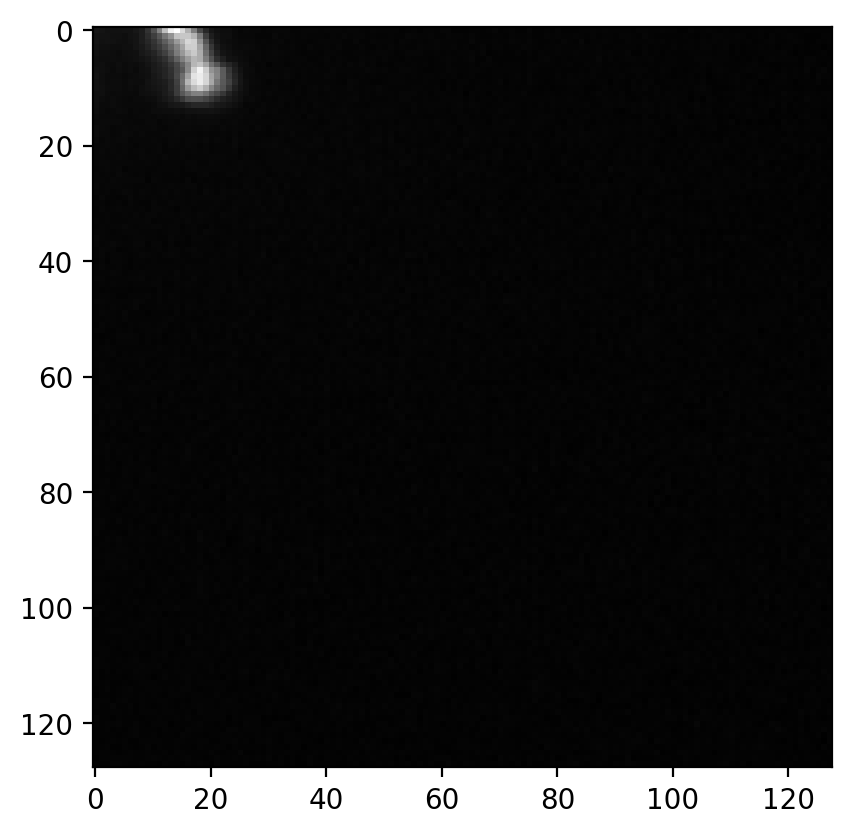

Channel DAPI(0) median = 152.0, mean = 152.84661865234375, std = 27.344421367509497


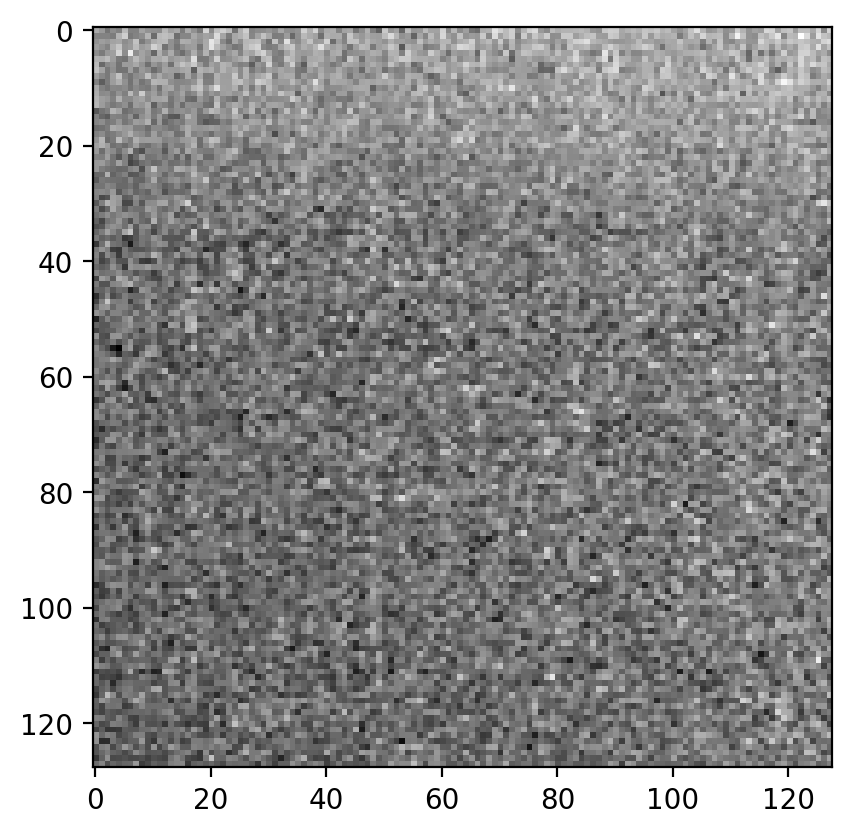

In [83]:
import tifffile

for i in range(10): 
    im_core_1_patch_0 = tifffile.imread(patch_1[i])
    im_core_1_patch_0[0,:,:]
    print("Channel DAPI(0) median = {}, mean = {}, std = {}".format(np.median(im_core_1_patch_0[0,:,:].flatten()), 
                                                        np.mean(im_core_1_patch_0[0,:,:].flatten()), 
                                                        np.std(im_core_1_patch_0[0,:,:].flatten())))
    plt.imshow(im_core_1_patch_0[0,:,:], cmap='gray')
    plt.show()

Channel DAPI(0) median = 8967.5, mean = 12360.293029785156, std = 10356.210569820656


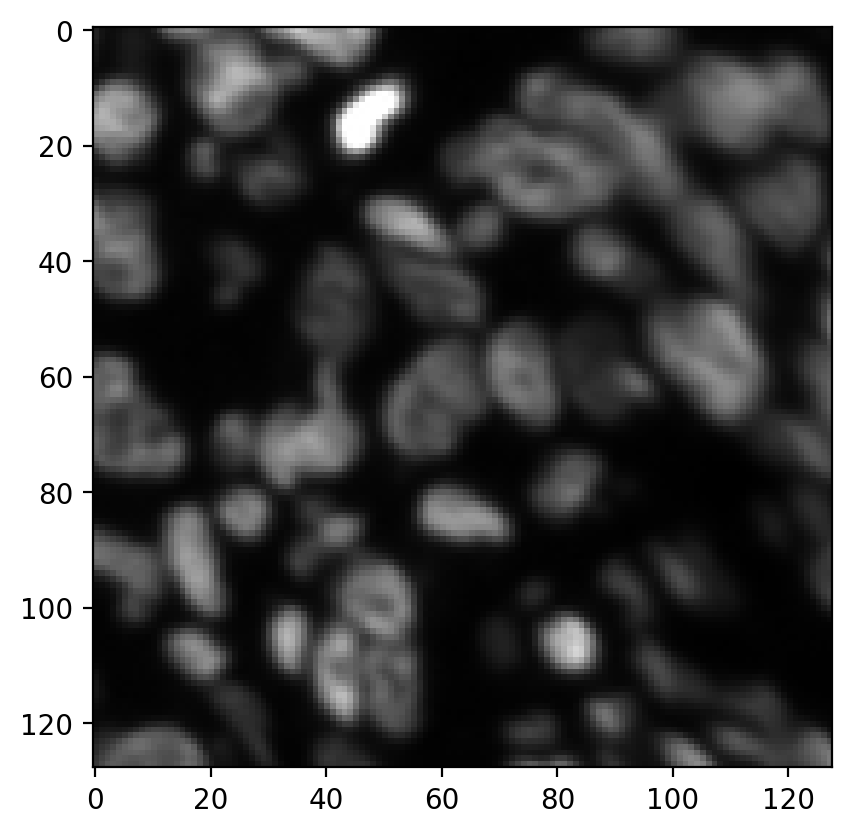

Channel DAPI(0) median = 852.0, mean = 1448.206787109375, std = 2270.2476234305846


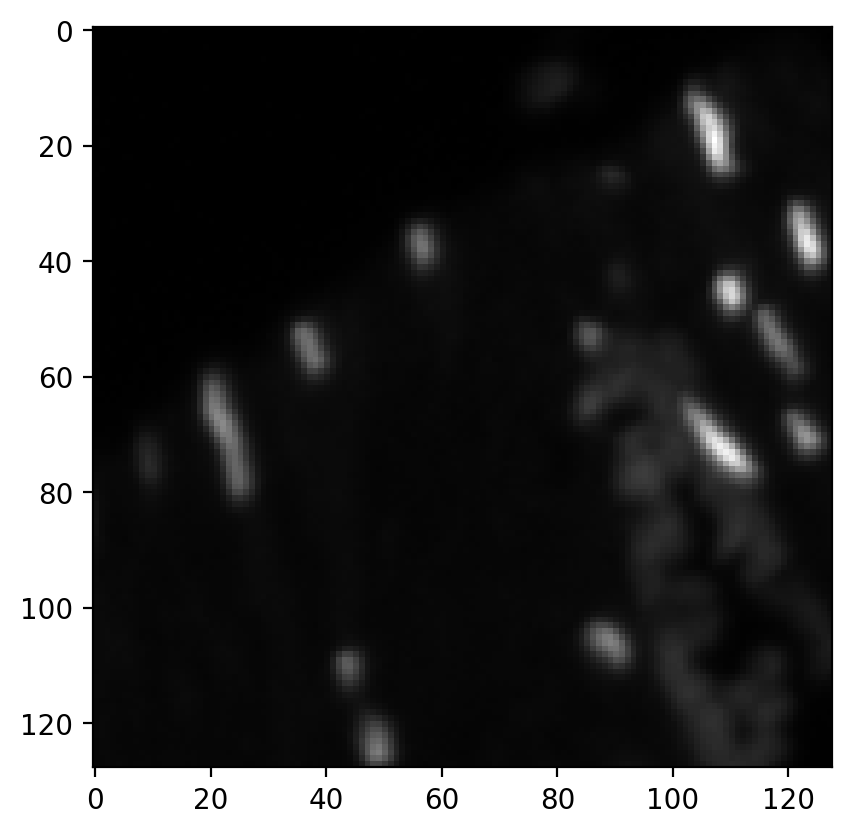

Channel DAPI(0) median = 8221.0, mean = 12655.142028808594, std = 12752.22149342476


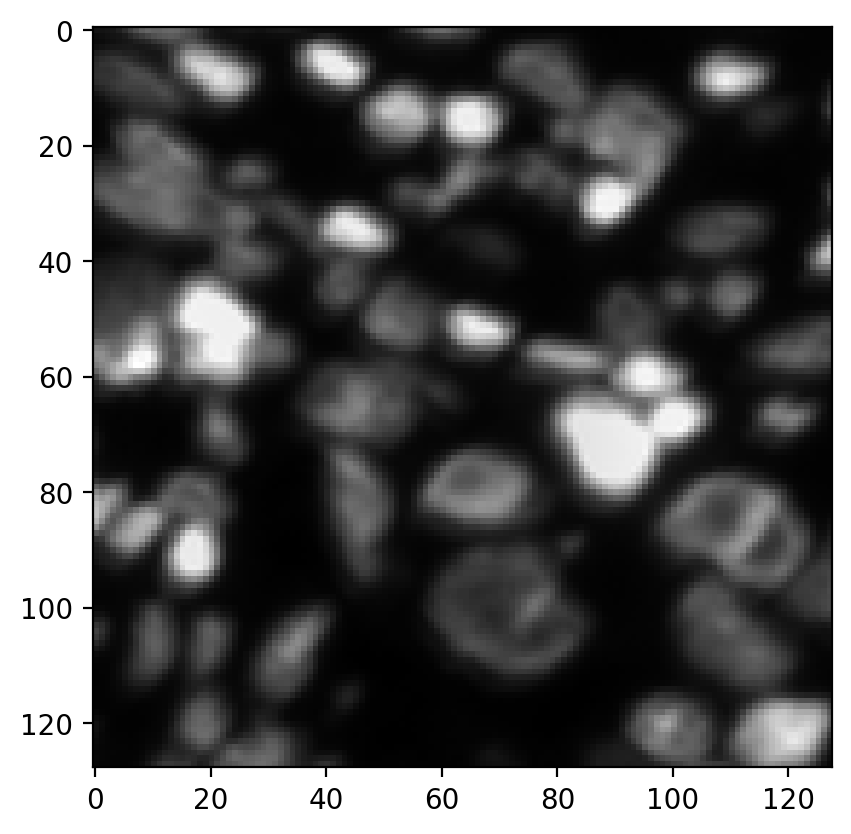

Channel DAPI(0) median = 939.0, mean = 2207.0228271484375, std = 4489.154163220895


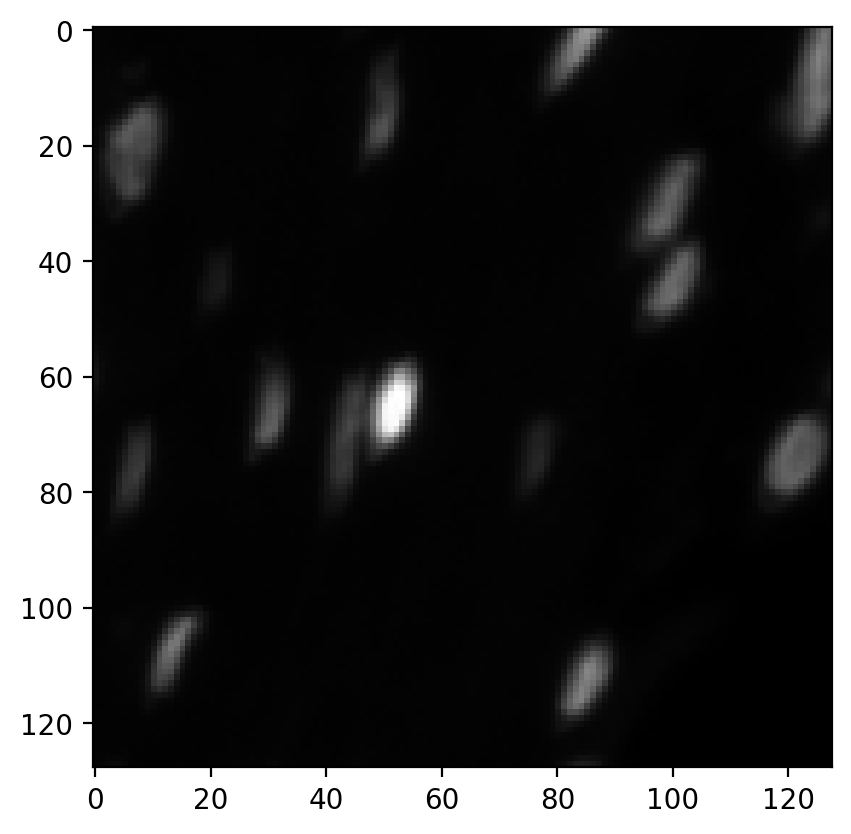

Channel DAPI(0) median = 3384.5, mean = 9089.798461914062, std = 11326.982555550818


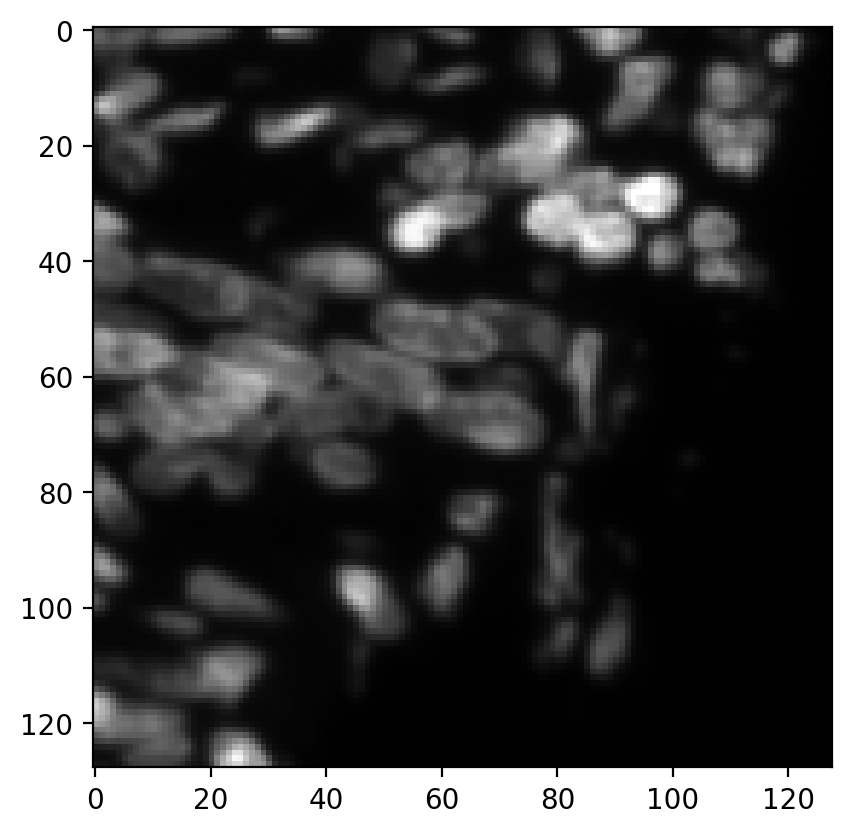

Channel DAPI(0) median = 1966.0, mean = 6047.3011474609375, std = 7990.01300521437


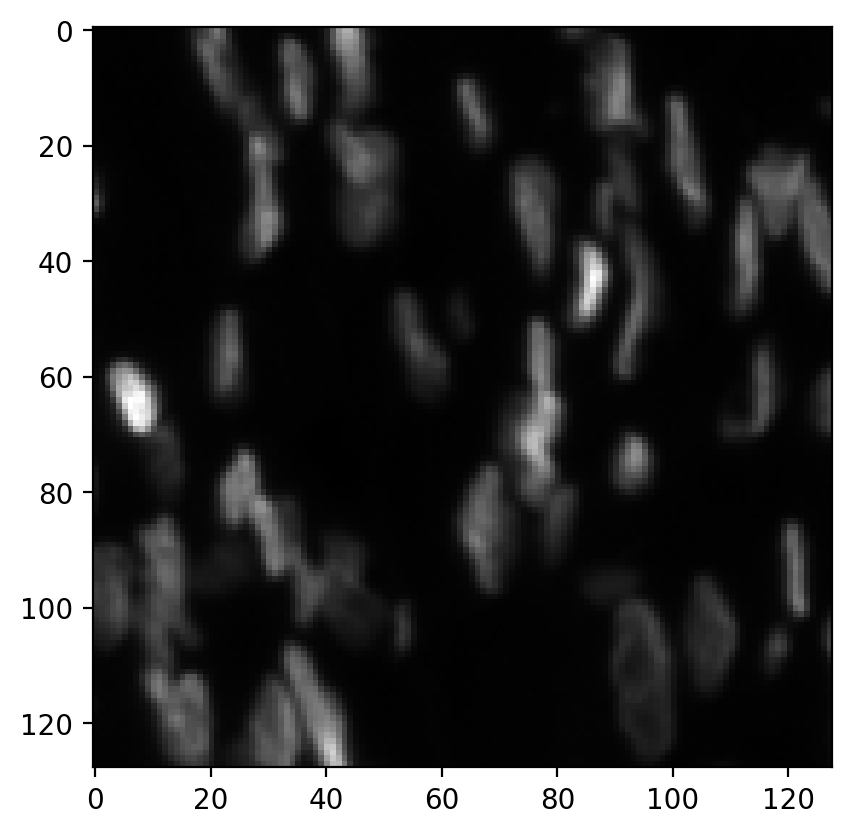

Channel DAPI(0) median = 2508.0, mean = 6141.776123046875, std = 9043.73621088251


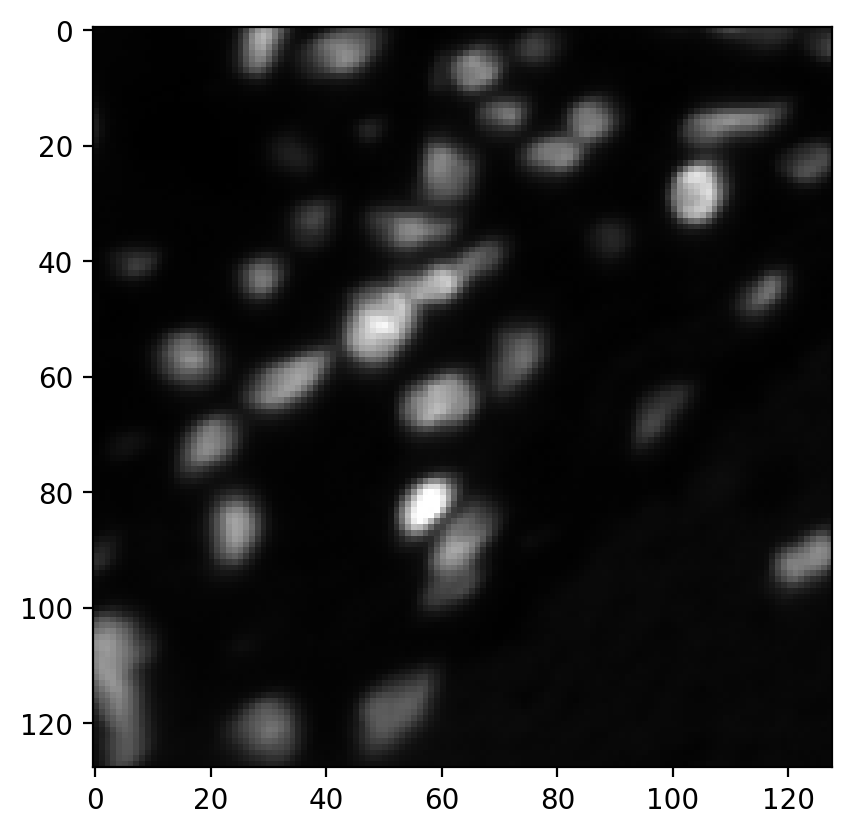

Channel DAPI(0) median = 2805.0, mean = 6957.997314453125, std = 9204.402780816712


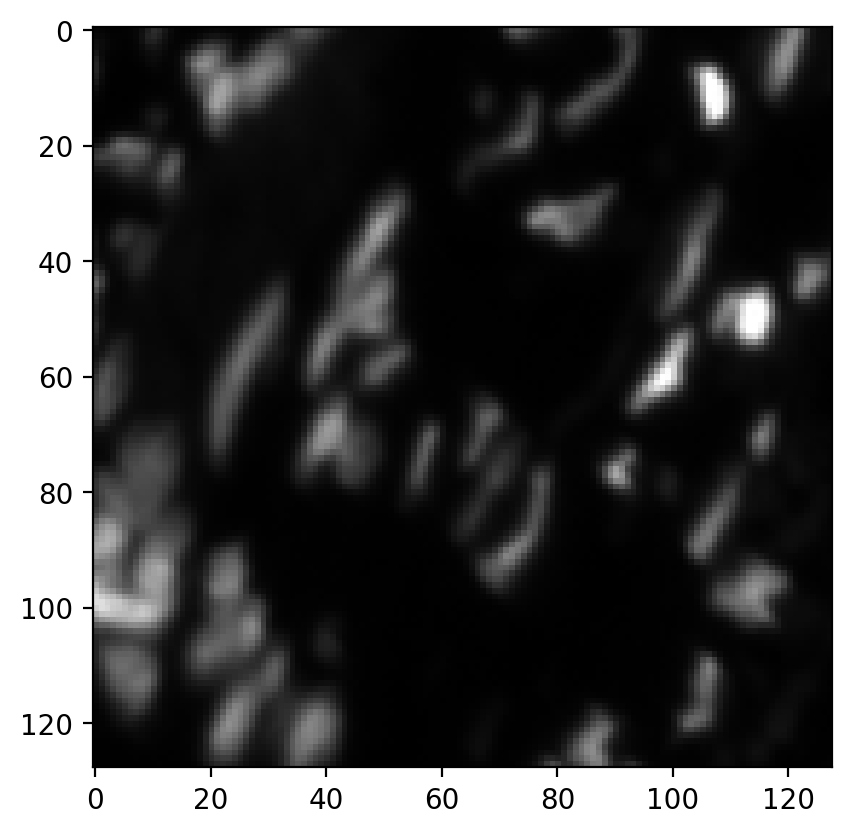

Channel DAPI(0) median = 1153.0, mean = 3946.3630981445312, std = 7970.930713850357


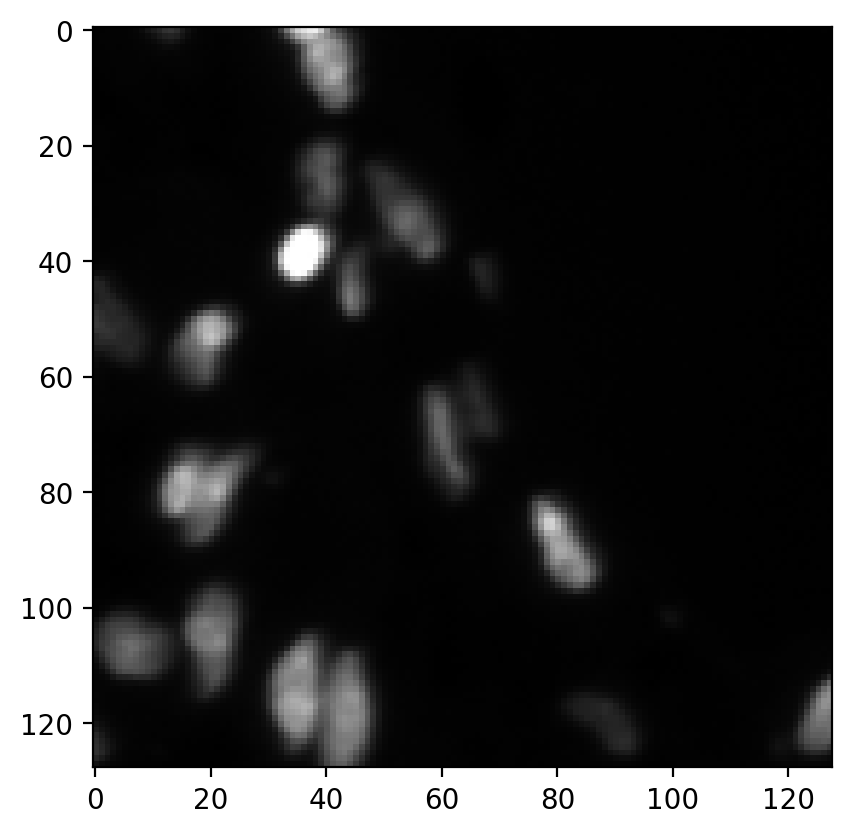

Channel DAPI(0) median = 1506.0, mean = 4908.118103027344, std = 8492.303979862078


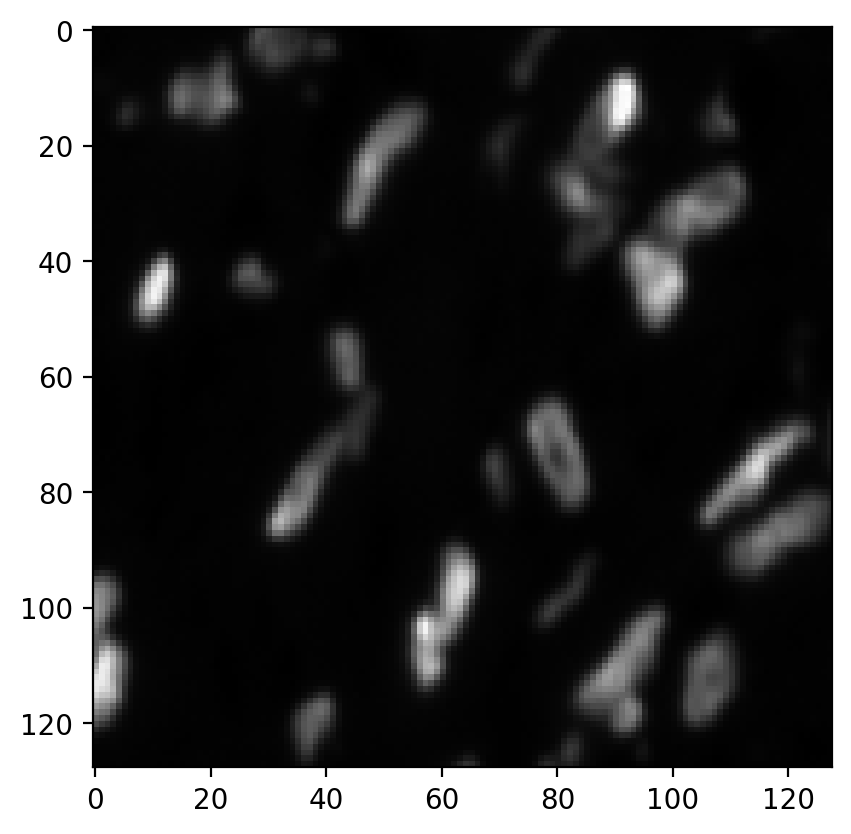

In [84]:
for i in range(10): 
    im_core_1_patch_0 = tifffile.imread(patch_2[i])
    im_core_1_patch_0[0,:,:]
    print("Channel DAPI(0) median = {}, mean = {}, std = {}".format(np.median(im_core_1_patch_0[0,:,:].flatten()), 
                                                        np.mean(im_core_1_patch_0[0,:,:].flatten()), 
                                                        np.std(im_core_1_patch_0[0,:,:].flatten())))
    plt.imshow(im_core_1_patch_0[0,:,:], cmap='gray')
    plt.show()

### TSNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 53959 samples in 0.108s...
[t-SNE] Computed neighbors for 53959 samples in 17.585s...
[t-SNE] Computed conditional probabilities for sample 1000 / 53959
[t-SNE] Computed conditional probabilities for sample 2000 / 53959
[t-SNE] Computed conditional probabilities for sample 3000 / 53959
[t-SNE] Computed conditional probabilities for sample 4000 / 53959
[t-SNE] Computed conditional probabilities for sample 5000 / 53959
[t-SNE] Computed conditional probabilities for sample 6000 / 53959
[t-SNE] Computed conditional probabilities for sample 7000 / 53959
[t-SNE] Computed conditional probabilities for sample 8000 / 53959
[t-SNE] Computed conditional probabilities for sample 9000 / 53959
[t-SNE] Computed conditional probabilities for sample 10000 / 53959
[t-SNE] Computed conditional probabilities for sample 11000 / 53959
[t-SNE] Computed conditional probabilities for sample 12000 / 53959
[t-SNE] Computed conditional probabilities for s

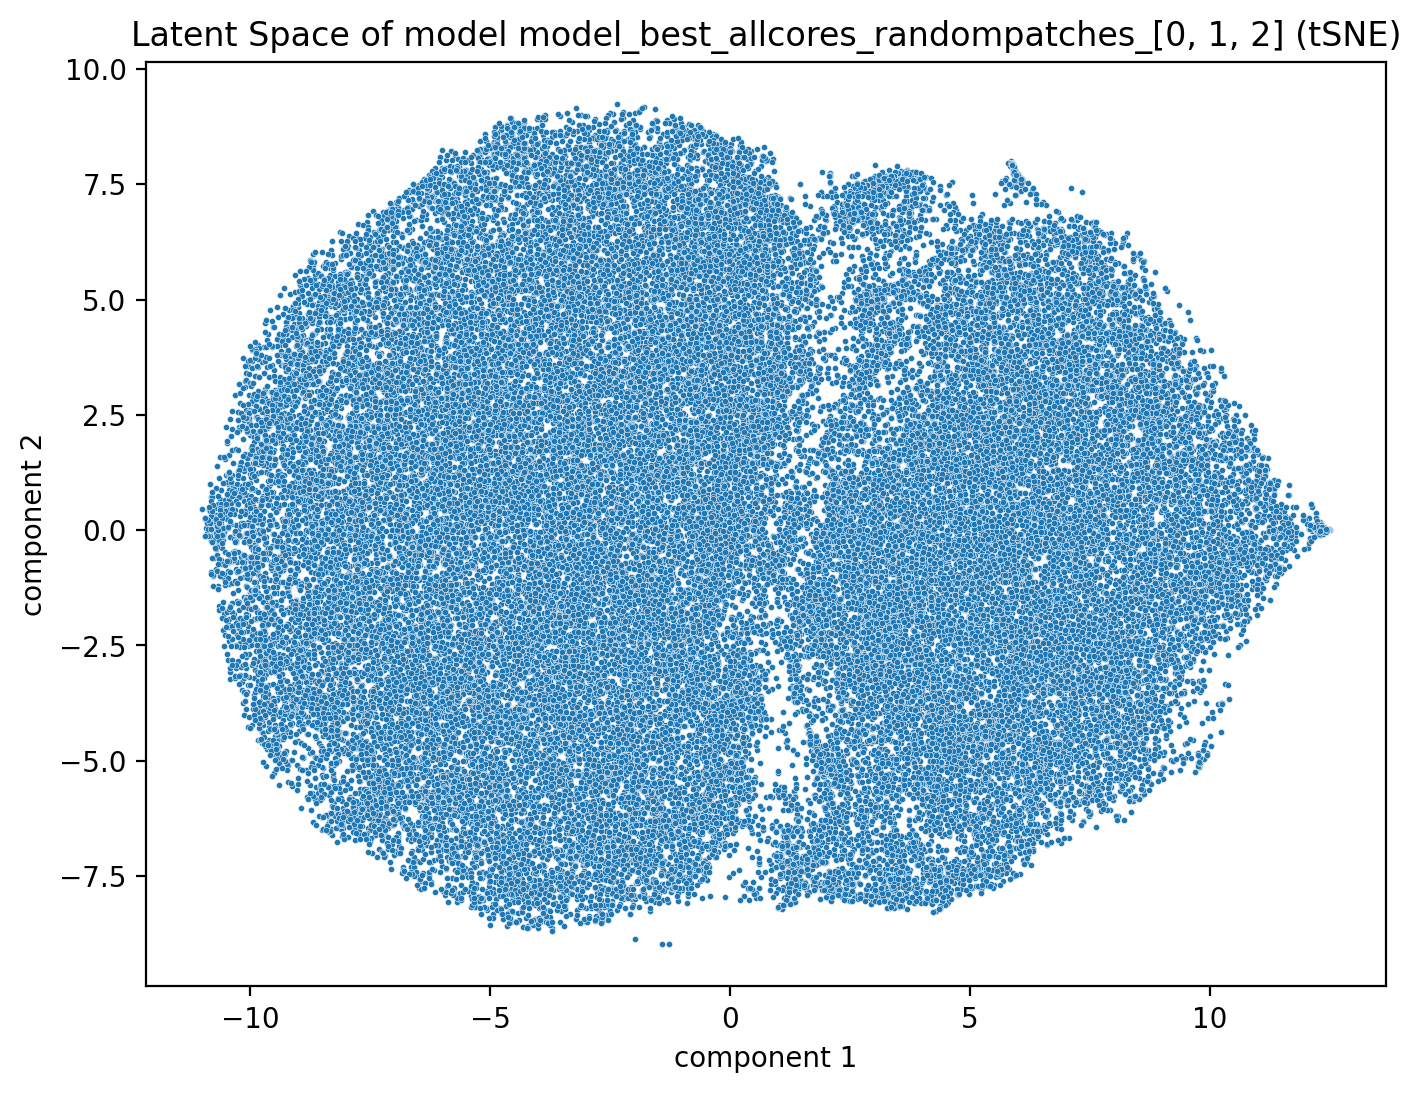

In [56]:
proj_2d_tsne = pd.DataFrame(
        data=TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(all_value),
        columns=["component 1", "component 2"]
        )

plt.figure(figsize=(8, 6))
sns.scatterplot(data=proj_2d_tsne, x="component 1", y="component 2", alpha=1, s=5)
plt.title("Latent Space of model {} (tSNE)".format(model_name))
plt.show()